# USA Spending Problem: Number of Distinct US Contractors

### Objective:
- Finding the number of distinct contractors awarded contracts by US Agencies in Year 2016

### Disclaimer: 
 - All the data for this problem was acquired from the [USA Spending Download Center](https://www.usaspending.gov/download_center/award_data_archive). 
 - This work was done by *Amir A. Taghavey* as a practice problem prior to the full interview with **Tamr** on Wed. 7/21/21.

### Importing / installing the required libraries (just in case):

In [6]:
# ! pip install pathlib

In [39]:
# importing the necessary libraries:
from zipfile import ZipFile
from pathlib import Path
import dill

import pandas as pd
import re

### Unzipping *.csv files and merging data tables into one pandas dataframe

In [ ]:
# %%time
# try:
#     # Loading the USA Spent 2016 data from file (if exists):
#     with open('df-USASepnt-2016.pkd', 'rb') as f:
#         all_csvs = dill.load(f)
# except:
#     with ZipFile('FY2016_All_Contracts_Full_20210707.zip', 'r') as usasp_2016_zip_obj:
#         usasp_2016_zip_obj.extractall('USA-Sepnt-2016-data')
#     files = Path('./USA-Sepnt-2016-data/').rglob('*.csv')
#     all_csvs = [pd.read_csv(file, low_memory=False) for file in files]
#     all_csvs = pd.concat(all_csvs)
#     # saving a copy of the compiled USA Spending data:
#     with open ('df-USASepnt-2016.pkd', 'wb') as f:
#         dill.dump(all_csvs, f)

In [17]:
# with ZipFile('FY2016_All_Contracts_Full_20210707.zip', 'r') as usasp_2016_zip_obj:
#     usasp_2016_zip_obj.extractall('USA-Sepnt-2016-data')

In [2]:
# files = Path('./USA-Sepnt-2016-data/').rglob('*.csv')
# files

<generator object Path.rglob at 0x0000026FEF0034A0>

In [3]:
# all_csvs = [pd.read_csv(file, low_memory=False) for file in files]

In [5]:
# all_csvs = pd.concat(all_csvs)

In [9]:
# # saving a copy of the aggregated USA Spending data for 2016:
# with open ('df-USASepnt-2016.pkd', 'wb') as f:
#     dill.dump(all_csvs, f)

In [2]:
# Loading the USA Spent 2016 data from file:
with open('df-USASepnt-2016.pkd', 'rb') as f:
    all_csvs = dill.load(f)

In [119]:
pd.set_option('display.memory_usage', 'deep')
all_csvs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4820334 entries, 0 to 820333
Columns: 282 entries, contract_transaction_unique_key to last_modified_date
dtypes: float64(25), int64(2), object(255)
memory usage: 67.9 GB


## Exploring USA Spending 2016 data:
- looking at the features and extracting the most relevant

In [98]:
# retrieving all the feature names from the dataframe
cols = ' | '.join(all_csvs.columns)
cols[:400]+' ... '+cols[-400:] 

'contract_transaction_unique_key | contract_award_unique_key | award_id_piid | modification_number | transaction_number | parent_award_agency_id | parent_award_agency_name | parent_award_id_piid | parent_award_modification_number | federal_action_obligation | total_dollars_obligated | base_and_exercised_options_value | current_total_value_of_award | base_and_all_options_value | potential_total_valu ... nsated_officer_1_name | highly_compensated_officer_1_amount | highly_compensated_officer_2_name | highly_compensated_officer_2_amount | highly_compensated_officer_3_name | highly_compensated_officer_3_amount | highly_compensated_officer_4_name | highly_compensated_officer_4_amount | highly_compensated_officer_5_name | highly_compensated_officer_5_amount | usaspending_permalink | last_modified_date'

In [24]:
all_csvs.shape

(4820334, 282)

In [249]:
all_csvs['award_type'].unique()

array(['DELIVERY ORDER', 'BPA CALL', 'PURCHASE ORDER',
       'DEFINITIVE CONTRACT', nan], dtype=object)

In [250]:
all_csvs['action_type'].unique()

array(['FUNDING ONLY ACTION', 'OTHER ADMINISTRATIVE ACTION', nan,
       'SUPPLEMENTAL AGREEMENT FOR WORK WITHIN SCOPE', 'CLOSE OUT',
       'EXERCISE AN OPTION', 'CHANGE ORDER',
       'ADDITIONAL WORK (NEW AGREEMENT,FAR PART 6 APPLIES)',
       'DEFINITIZE LETTER CONTRACT',
       'TERMINATE FOR CONVENIENCE (COMPLETE OR PARTIAL)',
       'DEFINITIZE CHANGE ORDER', 'LEGAL CONTRACT CANCELLATION',
       'ADDITIONAL WORK (NEW AGREEMENT, JUSTIFICATION REQUIRED)',
       'TRANSFER ACTION', 'CHANGE PIID', 'VENDOR ADDRESS CHANGE',
       'TERMINATE FOR DEFAULT (COMPLETE OR PARTIAL)',
       'NOVATION AGREEMENT', 'VENDOR DUNS OR NAME CHANGE - NON-NOVATION',
       'TERMINATE FOR CAUSE', 'REREPRESENTATION',
       'REREPRESENTATION OF NON-NOVATED MERGER/ACQUISITION',
       'UNIQUE ENTITY ID (DUNS) OR LEGAL BUSINESS NAME CHANGE - NON-NOVATION',
       'ENTITY ADDRESS CHANGE'], dtype=object)

In [88]:
'''
Data size reduction by selecting features relating only to awardees(contractors) and the awarding agencies ...
 ea. in a separate dataframe.
'''

cols_recipient = ['contract_transaction_unique_key',
                  'recipient_duns', 'recipient_name', 'recipient_doing_business_as_name', 
                  'recipient_parent_duns', 'recipient_parent_name', 
                  'recipient_country_code', 'recipient_country_name',
                  'recipient_address_line_1', 'recipient_address_line_2', 'recipient_city_name',
                  'recipient_county_name', 'recipient_state_code', 'recipient_state_name', 'recipient_zip_4_code',
                  'recipient_congressional_district', 
                  'recipient_phone_number', 'recipient_fax_number'
                 ]
cols_award = ['contract_transaction_unique_key',
              'total_dollars_obligated', 'current_total_value_of_award',
              'contract_transaction_unique_key', 'contract_award_unique_key', 'transaction_number',
              'awarding_agency_code', 'awarding_agency_name',
              'parent_award_agency_id', 'parent_award_agency_name'
              ]

- Filtering the data by (i) recipient info and (ii) award info

In [89]:
df_recipient = all_csvs[cols_recipient].copy()

In [90]:
df_award = all_csvs[cols_award].copy()

In [91]:
# # saving a copy og the recipient datafram:
# with open('USA-Spent-2016-summary.pkd', 'wb') as f:
#     dill.dump([df_recipient, df_award], f)

In [99]:
# verifying that contract_transaction_unique_key is the unflawed primary key of the USA Spending data
assert(len(df_recipient.contract_transaction_unique_key.unique())==all_csvs.shape[0])
df_recipient.contract_transaction_unique_key.nunique(), df_recipient.contract_transaction_unique_key.isna().sum()

(4820334, 0)

### Estimating the number of distinct contractors using several methods/features:

In [285]:
%%time
# normalizing recipient names to reduce redundancy:
normalize_txt = lambda x: ''.join(re.split(',|\.|_|-|the | the| of| at| ', str(x).lower().strip()))
normalize_txt_spaced = lambda x: ''.join(re.split(',|\.|_|-|THE | THE| OF| AT|', str(x).upper().strip()))
normalize_txt_abbreviated = lambda x: ''.join(s[0] if len(s) > 1 else s
                                              for s in re.split(',|\.|_|-|THE | THE| OF| AT| ', 
                                                                str(x).upper().strip()))
df_recipient['norm_name'] = df_recipient.recipient_name.apply(normalize_txt)
df_recipient['norm_name_spaced'] = df_recipient.recipient_name.apply(normalize_txt_spaced)
df_recipient['norm_name_abbv'] = df_recipient.recipient_name.apply(normalize_txt_abbreviated)

Wall time: 1min 1s


In [288]:
methods_dict = {
    'name': 'recipient_name',
    'name_normalized': 'norm_name',
    'name_normalized_spaced': 'norm_name_spaced',    
    'name_abbreviated': 'norm_name_abbv',
    'org_id': 'recipient_duns',
    'parent_org_id': 'recipient_parent_duns',
    'address': 'recipient_address_line_1',
    'phone': 'recipient_phone_number',
    'fax': 'recipient_fax_number',
    }

In [289]:
%%time

estimates = [[key, df_recipient[method].nunique(), df_recipient[method].isna().sum()] 
             for key, method in methods_dict.items()]

df_distict_contractor = pd.DataFrame(data=estimates, columns=['method', 'count', 'num_nans'], dtype=float)
pd.set_option('display.float_format', '{:,}'.format)
df_distict_contractor

Wall time: 5.7 s


,method,count,num_nans
0,name,"153,463.0",93.0
1,name_normalized,"149,322.0",0.0
2,name_normalized_spaced,"149,845.0",0.0
3,name_abbreviated,"52,541.0",0.0
4,org_id,"148,030.0",1.0
5,parent_org_id,"133,255.0","2,418.0"
6,address,"160,230.0",404.0
7,phone,"140,400.0","269,781.0"
8,fax,"113,836.0","621,360.0"


In [167]:
# pd.reset_option('all')

In [175]:
# finding the contract number for the one (1) entry missing the recipinet DUN number:
df_award[['contract_award_unique_key']].iloc[df_recipient[df_recipient.recipient_duns.isna()].index]

,contract_award_unique_key
431788,CONT_AWD_SPE7M916V4319_9700_-NONE-_-NONE-


## Additional Analysis

### - Top 10 Contractors:

- Top 10 by the **number of contracts**:

In [251]:
''' 
the merge method proved to be very computaionally expensive, 
so I decided to select columns direcly from the all_csvs master frame.'''
# df_merged = pd.merge(df_recipient[['contract_transaction_unique_key', 'recipient_duns', 'recipient_name']], 
#                      df_award[[]])
selected_cols = ['contract_transaction_unique_key', 
                  'recipient_duns', 'recipient_name', 'recipient_doing_business_as_name', 
                  'recipient_parent_duns', 'recipient_parent_name', 
                  'recipient_country_name', 'recipient_city_name', 'recipient_state_name', 'recipient_zip_4_code',
                  
                  'total_dollars_obligated', 'current_total_value_of_award',
                  'awarding_agency_name', 'parent_award_agency_name',
                  'action_type'
                  ]
df_merged = all_csvs[selected_cols].copy()
df_merged['norm_name_spaced'] = df_merged.recipient_name.apply(normalize_txt_space)

In [255]:
contracts = (
    df_merged[df_merged.action_type.isin(['FUNDING ONLY ACTION', 
                                          'SUPPLEMENTAL AGREEMENT FOR WORK WITHIN SCOPE',
                                          'ADDITIONAL WORK (NEW AGREEMENT,FAR PART 6 APPLIES)',
                                          'ADDITIONAL WORK (NEW AGREEMENT, JUSTIFICATION REQUIRED)',
                                          'NOVATION AGREEMENT'])]
             .groupby('recipient_duns')
             .agg({'norm_name_spaced': ['min'],
                   'contract_transaction_unique_key': ['count'],
                   'total_dollars_obligated': ['mean', 'sum']
                                                           })
            )
contracts.sort_values(by=('contract_transaction_unique_key', 'count'), ascending=False, inplace=True)
# pd.set_option('display.float_format', '{:,}'.format)
# pd.set_option('display.precision', 2)

In [256]:
contracts.head(10)

norm_name_spaced  \
                                                           min   
recipient_duns                                                   
123,456,787.0                   MISCELLANEOUS FOREIGN AWARDEES   
6,928,857.0                           BOOZ ALLEN  HAMILTON INC   
968,904,698.0                               CELLCO PARTNERSHIP   
95,633,152.0                CALIFORNIA INSTITUTE OF TECHNOLOGY   
78,883,327.0    SCIENCE APPLICATIONS INTERNATIONAL CORPORATION   
20,751,082.0                   MCI COMMUNICATIONS SERVICES INC   
39,860,122.0                                 XEROX CORPORATION   
8,016,958.0                        LOCKHEED MARTIN CORPORATION   
961,530,545.0                         URS FEDERAL SERVICES INC   
85,866,580.0                                     TW METALS INC   

               contract_transaction_unique_key total_dollars_obligated  \
                                         count                    mean   
recipient_duns                                                           
123,456,787.0                             3780      361,663.4236603333   
6,928,857.0                               2952     33,917,496.85736213   
968,904,698.0                             2371     273,807.34868852457   
95,633,152.0                              1603            4,624,895.77   
78,883,327.0                              1603     78,222,549.80230743   
20,751,082.0                              1416      440,326.8476351352   
39,860,122.0                              1149      97,101.00366972476   
8,016,958.0                               1148     134,254,162.9462643   
961,530,545.0                             1136    149,754,486.52452916   
85,866,580.0                              1101                  225.76   

                                     
                                sum  
recipient_duns                       
123,456,787.0   932,729,969.6199996  
6,928,857.0       36,902,236,580.81  
968,904,698.0  33,404,496.539999995  
95,633,152.0          69,373,436.55  
78,883,327.0    56,946,016,256.0798  
20,751,082.0          65,168,373.45  
39,860,122.0   21,168,018.799999997  
8,016,958.0    82,297,801,886.06001  
961,530,545.0  58,853,513,204.13996  
85,866,580.0                 451.52

- Top 10 by the highest **total dollar value of contracts**:

In [257]:
contracts.sort_values(by=('total_dollars_obligated', 'sum'), ascending=False, inplace=True)
contracts.head(10)

norm_name_spaced  \
                                                              min   
recipient_duns                                                      
14,513,647.0                                       BOEING COMPANY   
785,627,931.0   LAWRENCE LIVERMORE NATIONAL SECURITY LIMITED L...   
963,737,366.0                           ELECTRIC BOAT CORPORATION   
99,114,287.0                UT BATTELLE LIMITED LIABILITY COMPANY   
32,987,476.0                          BATTELLE MEMORIAL INSTITUTE   
926,784,042.0                         LOCKHEED MARTIN CORPORATION   
126,368,257.0                                  BOEING COMPANY THE   
9,214,214.0                        LELAND JUNIOR STANFORD UNIVERS   
805,603,128.0               CH2M HILL PLATEAU REMEDIATION COMPANY   
872,978,978.0                         LOCKHEED MARTIN CORPORATION   

               contract_transaction_unique_key total_dollars_obligated  \
                                         count                    mean   
recipient_duns                                                           
14,513,647.0                                89    18,964,707,189.69997   
785,627,931.0                               52    23,294,603,188.75327   
963,737,366.0                              447   15,442,391,119.910715   
99,114,287.0                                35   21,540,013,962.270008   
32,987,476.0                                32   18,851,443,289.549995   
926,784,042.0                              120    7,871,236,367.295998   
126,368,257.0                              151    4,599,123,391.329052   
9,214,214.0                                 74    8,841,790,405.459478   
805,603,128.0                               44    7,094,702,048.039999   
872,978,978.0                              224    4,382,631,238.090398   

                                       
                                  sum  
recipient_duns                         
14,513,647.0   1,687,858,939,883.2974  
785,627,931.0    1,211,319,365,815.17  
963,737,366.0       864,773,902,715.0  
99,114,287.0     753,900,488,679.4503  
32,987,476.0     603,246,185,265.5999  
926,784,042.0   511,630,363,874.23987  
126,368,257.0   340,335,130,958.34985  
9,214,214.0     335,988,035,407.46014  
805,603,128.0   312,166,890,113.75995  
872,978,978.0    219,131,561,904.5199

In [258]:
# Top ranking 
df_merged[(df_merged.norm_name_spaced=='ELECTRIC BOAT CORPORATION') 
          & (df_merged.current_total_value_of_award.notna())].head()

,contract_transaction_unique_key,recipient_duns,recipient_name,recipient_doing_business_as_name,recipient_parent_duns,recipient_parent_name,recipient_country_name,recipient_city_name,recipient_state_name,recipient_zip_4_code,total_dollars_obligated,current_total_value_of_award,awarding_agency_name,parent_award_agency_name,action_type,norm_name_spaced
21697,9700_-NONE-_N0002412C2115_A00165_-NONE-_0,"963,737,366.0",ELECTRIC BOAT CORPORATION,NaN,"1,381,284.0",GENERAL DYNAMICS CORPORATION,UNITED STATES,GROTON,CONNECTICUT,063404905,"17,885,611,571.0","17,894,197,942.0",DEPARTMENT OF DEFENSE (DOD),NaN,DEFINITIZE CHANGE ORDER,ELECTRIC BOAT CORPORATION
21718,9700_-NONE-_N0002410C2118_A00227_-NONE-_0,"963,737,366.0",ELECTRIC BOAT CORPORATION,NaN,"1,381,284.0",GENERAL DYNAMICS CORPORATION,UNITED STATES,GROTON,CONNECTICUT,063404905,"1,394,452,356.0","1,485,636,429.0",DEPARTMENT OF DEFENSE (DOD),NaN,DEFINITIZE CHANGE ORDER,ELECTRIC BOAT CORPORATION
21732,9700_-NONE-_N0002412C2115_A00166_-NONE-_0,"963,737,366.0",ELECTRIC BOAT CORPORATION,NaN,"1,381,284.0",GENERAL DYNAMICS CORPORATION,UNITED STATES,GROTON,CONNECTICUT,063404905,"17,885,611,571.0","17,894,197,942.0",DEPARTMENT OF DEFENSE (DOD),NaN,DEFINITIZE CHANGE ORDER,ELECTRIC BOAT CORPORATION
21741,9700_-NONE-_N0002412C2115_A00167_-NONE-_0,"963,737,366.0",ELECTRIC BOAT CORPORATION,NaN,"1,381,284.0",GENERAL DYNAMICS CORPORATION,UNITED STATES,GROTON,CONNECTICUT,063404905,"17,885,611,571.0","17,894,197,942.0",DEPARTMENT OF DEFENSE (DOD),NaN,SUPPLEMENTAL AGREEMENT FOR WORK WITHIN SCOPE,ELECTRIC BOAT CORPORATION
22818,9700_-NONE-_N6278916P0052_0_-NONE-_0,"963,737,366.0",ELECTRIC BOAT CORPORATION,NaN,"1,381,284.0",GENERAL DYNAMICS CORPORATION,UNITED STATES,GROTON,CONNECTICUT,063404905,"4,038.84","4,038.84",DEPARTMENT OF DEFENSE (DOD),NaN,NaN,ELECTRIC BOAT CORPORATION


- Top 10 by the highest **mean contract value**:

In [259]:
contracts.sort_values(by=('total_dollars_obligated', 'mean'), ascending=False, inplace=True)
contracts.head(10)

norm_name_spaced  \
                                                              min   
recipient_duns                                                      
7,113,228.0                                           SANDIA CORP   
175,252,894.0   LOS ALAMOS NATIONAL SECURITY LIMITED LIABILITY...   
785,627,931.0   LAWRENCE LIVERMORE NATIONAL SECURITY LIMITED L...   
99,114,287.0                UT BATTELLE LIMITED LIABILITY COMPANY   
14,513,647.0                                       BOEING COMPANY   
32,987,476.0                          BATTELLE MEMORIAL INSTITUTE   
78,390,708.0                    CONSOLIDATED NUCLEAR SECURITY LLC   
963,737,366.0                           ELECTRIC BOAT CORPORATION   
9,214,214.0                        LELAND JUNIOR STANFORD UNIVERS   
926,784,042.0                         LOCKHEED MARTIN CORPORATION   

               contract_transaction_unique_key total_dollars_obligated  \
                                         count                    mean   
recipient_duns                                                           
7,113,228.0                                 25    48,080,056,275.71999   
175,252,894.0                               55   27,426,377,514.003338   
785,627,931.0                               52    23,294,603,188.75327   
99,114,287.0                                35   21,540,013,962.270008   
14,513,647.0                                89    18,964,707,189.69997   
32,987,476.0                                32   18,851,443,289.549995   
78,390,708.0                                32   17,964,686,582.128334   
963,737,366.0                              447   15,442,391,119.910715   
9,214,214.0                                 74    8,841,790,405.459478   
926,784,042.0                              120    7,871,236,367.295998   

                                       
                                  sum  
recipient_duns                         
7,113,228.0     144,240,168,827.15997  
175,252,894.0    82,279,132,542.01001  
785,627,931.0    1,211,319,365,815.17  
99,114,287.0     753,900,488,679.4503  
14,513,647.0   1,687,858,939,883.2974  
32,987,476.0     603,246,185,265.5999  
78,390,708.0       107,788,119,492.77  
963,737,366.0       864,773,902,715.0  
9,214,214.0     335,988,035,407.46014  
926,784,042.0   511,630,363,874.23987

<AxesSubplot:xlabel='(norm_name_spaced, min)'>

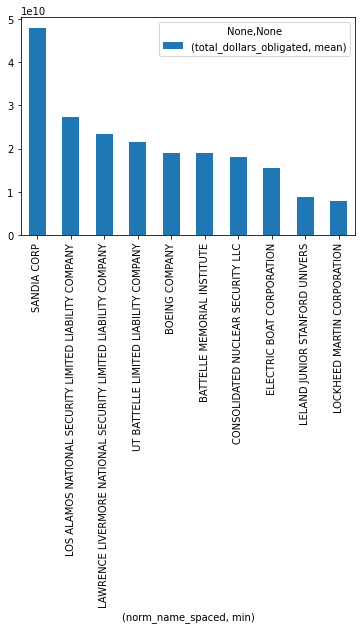

In [260]:
((contracts[[('norm_name_spaced', 'min'), ('total_dollars_obligated', 'mean')]]
 .head(10))
 .set_index(('norm_name_spaced', 'min'))
 .plot.bar())

### - Top Funding Agencies:

In [261]:
agencies = (
    df_merged[df_merged.action_type.isin(['FUNDING ONLY ACTION', 
                                          'SUPPLEMENTAL AGREEMENT FOR WORK WITHIN SCOPE',
                                          'ADDITIONAL WORK (NEW AGREEMENT,FAR PART 6 APPLIES)',
                                          'ADDITIONAL WORK (NEW AGREEMENT, JUSTIFICATION REQUIRED)',
                                          'NOVATION AGREEMENT'])]
    .groupby('awarding_agency_name')
    .agg({'norm_name_spaced': ['count'],
          'contract_transaction_unique_key': ['count'],
          'total_dollars_obligated': ['mean', 'sum']})
            )
agencies.sort_values(by=('contract_transaction_unique_key', 'count'), ascending=False, inplace=True)

In [262]:
agencies.head(10)

norm_name_spaced  \
                                                              count   
awarding_agency_name                                                  
DEPARTMENT OF DEFENSE (DOD)                                  184650   
DEPARTMENT OF VETERANS AFFAIRS (VA)                           32718   
DEPARTMENT OF JUSTICE (DOJ)                                   31054   
DEPARTMENT OF HOMELAND SECURITY (DHS)                         15911   
DEPARTMENT OF THE INTERIOR (DOI)                              13610   
NATIONAL AERONAUTICS AND SPACE ADMINISTRATION (...            13399   
DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS)                 11903   
GENERAL SERVICES ADMINISTRATION (GSA)                         11319   
DEPARTMENT OF AGRICULTURE (USDA)                               9824   
DEPARTMENT OF TRANSPORTATION (DOT)                             8703   

                                                   contract_transaction_unique_key  \
                                                                             count   
awarding_agency_name                                                                 
DEPARTMENT OF DEFENSE (DOD)                                                 184650   
DEPARTMENT OF VETERANS AFFAIRS (VA)                                          32718   
DEPARTMENT OF JUSTICE (DOJ)                                                  31054   
DEPARTMENT OF HOMELAND SECURITY (DHS)                                        15911   
DEPARTMENT OF THE INTERIOR (DOI)                                             13610   
NATIONAL AERONAUTICS AND SPACE ADMINISTRATION (...                           13399   
DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS)                                11903   
GENERAL SERVICES ADMINISTRATION (GSA)                                        11319   
DEPARTMENT OF AGRICULTURE (USDA)                                              9824   
DEPARTMENT OF TRANSPORTATION (DOT)                                            8703   

                                                   total_dollars_obligated  \
                                                                      mean   
awarding_agency_name                                                         
DEPARTMENT OF DEFENSE (DOD)                             90,615,510.2504425   
DEPARTMENT OF VETERANS AFFAIRS (VA)                    5,672,791.124309257   
DEPARTMENT OF JUSTICE (DOJ)                           3,510,720.9700064906   
DEPARTMENT OF HOMELAND SECURITY (DHS)                 15,150,999.866331272   
DEPARTMENT OF THE INTERIOR (DOI)                        8,894,098.75917818   
NATIONAL AERONAUTICS AND SPACE ADMINISTRATION (...     730,142,003.3879246   
DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS)          45,080,036.73051781   
GENERAL SERVICES ADMINISTRATION (GSA)                  28,027,703.45750591   
DEPARTMENT OF AGRICULTURE (USDA)                       7,676,663.128333306   
DEPARTMENT OF TRANSPORTATION (DOT)                    30,645,706.608196996   

                                                                           
                                                                      sum  
awarding_agency_name                                                       
DEPARTMENT OF DEFENSE (DOD)                        3,341,446,940,485.0674  
DEPARTMENT OF VETERANS AFFAIRS (VA)                 19,627,857,290.110027  
DEPARTMENT OF JUSTICE (DOJ)                         10,813,020,587.619991  
DEPARTMENT OF HOMELAND SECURITY (DHS)               22,135,610,804.709988  
DEPARTMENT OF THE INTERIOR (DOI)                    10,930,847,375.029984  
NATIONAL AERONAUTICS AND SPACE ADMINISTRATION (...  2,713,207,684,589.528  
DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS)        91,422,314,489.49013  
GENERAL SERVICES ADMINISTRATION (GSA)                60,455,756,357.84025  
DEPARTMENT OF AGRICULTURE (USDA)                    13,127,093,949.449953  
DEPARTMENT OF TRANSPORTATION (DOT)                      55,070,334,774.93

<AxesSubplot:xlabel='awarding_agency_name'>

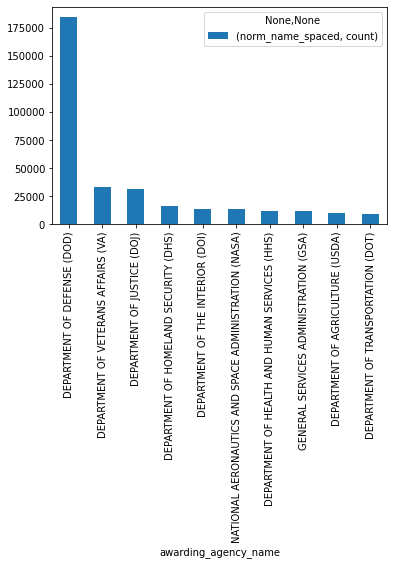

In [263]:
agencies[[('norm_name_spaced', 'count')]].head(10).plot.bar()

### - Contracts awarded to **non-US based entities**:

- number of countries with awarded contractors:

In [245]:
df_merged.recipient_country_name[(df_merged.recipient_country_name!='UNITED STATES') & 
                                 df_merged.total_dollars_obligated>0].nunique()

146

- Countries with the highest **number of awarded contracts**:

In [264]:
countries = (
    df_merged[df_merged.action_type.isin(['FUNDING ONLY ACTION', 
                                      'SUPPLEMENTAL AGREEMENT FOR WORK WITHIN SCOPE',
                                      'ADDITIONAL WORK (NEW AGREEMENT,FAR PART 6 APPLIES)',
                                      'ADDITIONAL WORK (NEW AGREEMENT, JUSTIFICATION REQUIRED)',
                                      'NOVATION AGREEMENT'])]
    .groupby('recipient_country_name')
    .agg({'contract_transaction_unique_key': ['count'],
          'total_dollars_obligated': ['mean', 'sum']})
            )

countries.sort_values(by=('contract_transaction_unique_key', 'count'), ascending=False, inplace=True)
countries[countries.index!='UNITED STATES'].head(10)

contract_transaction_unique_key  \
                                                 count   
recipient_country_name                                   
JAPAN                                             3929   
GERMANY                                           1786   
KOREA, SOUTH                                       849   
CANADA                                             750   
UNITED KINGDOM                                     625   
ITALY                                              559   
MALTA                                              482   
KUWAIT                                             407   
SINGAPORE                                          350   
TURKEY                                             335   

                       total_dollars_obligated                        
                                          mean                   sum  
recipient_country_name                                                
JAPAN                      9,497,315.332606634 2,003,933,535.1799998  
GERMANY                      5,603,594.8356621      1,227,187,269.01  
KOREA, SOUTH               187,629,373.7493987  24,954,706,708.67003  
CANADA                     41,384,234.02044443 3,724,581,061.8399987  
UNITED KINGDOM               619,893.583624161   92,364,143.95999998  
ITALY                     1,142,692.9238461538  44,565,024.029999994  
MALTA                      124,916.40666666666            374,749.22  
KUWAIT                      9,077,053.94472973   671,701,991.9100001  
SINGAPORE                   50,973.48818181819  1,121,416.7400000002  
TURKEY                    2,071,663.8007894736   78,723,224.42999999

- Countries with the highest **dollar value of contracts**:

In [265]:
countries.sort_values(by=('total_dollars_obligated', 'sum'), ascending=False, inplace=True)
countries[(countries.index!='UNITED STATES')].head(10)

contract_transaction_unique_key  \
                                                 count   
recipient_country_name                                   
KOREA, SOUTH                                       849   
CANADA                                             750   
JAPAN                                             3929   
GERMANY                                           1786   
SAUDI ARABIA                                       131   
KUWAIT                                             407   
RUSSIA                                              19   
AFGHANISTAN                                        174   
UNITED ARAB EMIRATES                               264   
BELGIUM                                             64   

                       total_dollars_obligated                        
                                          mean                   sum  
recipient_country_name                                                
KOREA, SOUTH               187,629,373.7493987  24,954,706,708.67003  
CANADA                     41,384,234.02044443 3,724,581,061.8399987  
JAPAN                      9,497,315.332606634 2,003,933,535.1799998  
GERMANY                      5,603,594.8356621      1,227,187,269.01  
SAUDI ARABIA               26,453,834.46342857        925,884,206.22  
KUWAIT                      9,077,053.94472973   671,701,991.9100001  
RUSSIA                           106,226,731.7         531,133,658.5  
AFGHANISTAN               11,243,855.613157894         427,266,513.3  
UNITED ARAB EMIRATES      2,869,666.6759259254  154,962,000.49999997  
BELGIUM                   12,847,437.746666668        154,169,252.96

<AxesSubplot:xlabel='recipient_country_name'>

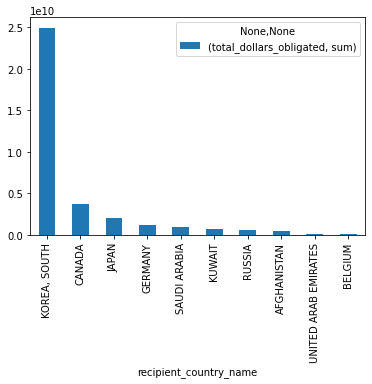

In [266]:
countries[[('total_dollars_obligated', 'sum')]][countries.index!='UNITED STATES'].head(10).plot.bar()

- Countries with the lowest **dollar value of contracts**:

In [267]:
countries.sort_values(by=('total_dollars_obligated', 'sum'), ascending=False, inplace=True)
countries[(countries.index!='UNITED STATES') 
          & (countries[('total_dollars_obligated', 'sum')]>0)].tail(10)

contract_transaction_unique_key  \
                                                 count   
recipient_country_name                                   
SWITZERLAND                                         33   
CAMEROON                                            18   
UKRAINE                                              7   
TANZANIA                                             8   
TAIWAN                                               2   
PORTUGAL                                            20   
DOMINICAN REPUBLIC                                   5   
BOSNIA AND HERZEGOVINA                              19   
MOROCCO                                              4   
KOSOVO                                               1   

                       total_dollars_obligated                     
                                          mean                sum  
recipient_country_name                                             
SWITZERLAND                  3,831.40652173913 88,122.34999999999  
CAMEROON                              87,856.0           87,856.0  
UKRAINE                             37,854.405          75,708.81  
TANZANIA                              67,760.0           67,760.0  
TAIWAN                               33,483.43          33,483.43  
PORTUGAL                             20,722.82          20,722.82  
DOMINICAN REPUBLIC                   15,034.35          15,034.35  
BOSNIA AND HERZEGOVINA               3,171.745           6,343.49  
MOROCCO                                1,500.0            1,500.0  
KOSOVO                                 1,000.0            1,000.0

## Misc:

Building the text normalizer method (exploratory)

In [23]:
df_recipient['recipient_name'].head()

0                          TETRA TECH EM, INC.
1    TRIDENT ENGINEERING AND PROCUREMENT, P.C.
2                                 NORESCO, LLC
3                           TECH SYSTEMS, INC.
4                          NETIZEN CORPORATION
Name: recipient_name, dtype: object

In [59]:
str_ = 'TRIDENT ENGINEERING AND PROCUREMENT, P.C. CONFEDERATED TRIBES OF THE COLVILLE RESERVATION, THE T-SYSTEM, INC.'
''.join(char for char in str_.strip().lower() if char.isalnum())

'tridentengineeringandprocurementpcconfederatedtribesofthecolvillereservationthetsysteminc'

In [62]:
''.join(re.split(',|\.|_|-|the | the| of| at| ', str_.lower().strip()))

'tridentengineeringandprocurementpcconfederatedtribescolvillereservationtsysteminc'

In [291]:
name = 'Inter Bisness Management '
normalize_txt_abbreviated(name), normalize_txt_spaced(name)

('IBM', 'INTER BISNESS MANAGEMENT')